# 第十一週：Text Embeddings

本週課程為「Text Embeddings」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers套件和API取得embeddings。

### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：chinese / multilingual
  *   大模型（LLM）：
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('雲端資料夾路徑') #切換該目錄
os.listdir() #確認目錄內容

In [ ]:
# !pip install jieba
# !pip install "gensim==4.3.3" "spacy==3.7.2" "thinc==8.2.2"

如果安裝套件時遇到跟 numpy 相關錯誤的話，可以嘗試執行以下程式碼

In [ ]:
# 先清除舊的 numpy
!pip uninstall -y numpy

# 安裝對應版本
!pip install numpy==1.26.4 gensim==4.3.3 spacy==3.7.2 thinc==8.2.2

# 強制重啟 Runtime
import os
os.kill(os.getpid(), 9)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

In [2]:
# Seed utilities, copied from previous project

import torch
import random
import numpy as np
from numpy import random as np_random
from numpy.random import Generator, BitGenerator, RandomState, SeedSequence
from collections.abc import Sequence, Callable
from typing import Any, TypeAlias, TypeVar
import inspect
import functools

T = TypeVar("T")

def copy_special(target: T, source: Any, *names: str) -> T:
    for name in names:
        attribute = f"__{name}__"
        setattr(target, attribute, getattr(source, attribute))
    return target

NumpySeed: TypeAlias = None | int | Sequence[int] | SeedSequence | BitGenerator | Generator | RandomState

def patch_numpy_random_default_rng(seed: NumpySeed=0) -> Callable[[NumpySeed], Generator]:
    FUNCTION_NAME = "default_rng"
    ATTRIBUTE_NAME = f"{np_random.__name__}.{FUNCTION_NAME}"
    COPY_ATTRIBUTE_NAMES = ("name", "doc", "qualname")

    get_current = lambda: getattr(np_random, FUNCTION_NAME)
    get_original = lambda: getattr(np_random, ATTRIBUTE_NAME, get_current())
    (current_module_name, numpy_module_name) = map(lambda module: module.__name__, (inspect.getmodule(get_current), np))
    is_original = current_module_name == numpy_module_name or current_module_name.startswith(f"{numpy_module_name}.")

    if seed is None:
        if is_original:
            return get_current
        original = get_original()
        setattr(np_random, FUNCTION_NAME, original)
        return original
    else:
        original = get_current
        if is_original:
            setattr(np_random, ATTRIBUTE_NAME, original)
        else:
            original = get_original()

        def default_rng(original: Callable[[NumpySeed], Generator], seed: NumpySeed=seed) -> Generator:
            return original(seed)
        copy_special(default_rng, original, *COPY_ATTRIBUTE_NAMES)
        partial = functools.partial(default_rng, original)
        copy_special(partial, default_rng, *COPY_ATTRIBUTE_NAMES, "module")

        setattr(np_random, FUNCTION_NAME, partial)
        return original

def enable_deterministic_torch() -> None:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)

def set_seed(seed: int, deterministic: bool=True, patch_numpy: bool=True) -> None:
    if deterministic:
        enable_deterministic_torch()
    torch.manual_seed(seed)
    seed_non_torch(seed, patch_numpy)

def seed_non_torch(seed: int, patch_numpy: bool=True) -> None:
    random.seed(seed)
    np_random.seed(seed)
    patch_numpy_random_default_rng(seed if patch_numpy else None)

def seed_worker(worker_id: int) -> None:
    enable_deterministic_torch()
    seed_non_torch(torch.initial_seed() % 2 ** 32)

In [3]:
# Ensure results reproducibility of CUDA cuBLAS API
%env CUBLAS_WORKSPACE_CONFIG :4096:8

%env PYTHONHASHSEED=2025

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=2025


In [4]:
GLOBAL_SEED=2025
set_seed(GLOBAL_SEED)

### 資料前處理

讀入資料集

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#jieba.load_userdict('./dict/user_dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [6]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [7]:
# 讀入中文資料集
origin_data_parttime = pd.read_csv('./raw_data/ptt_parttime.csv')
origin_data_techjob = pd.read_csv('./raw_data/ptt_techjob.csv')
origin_data_softjob = pd.read_csv('./raw_data/ptt_softjob.csv')

origin_data = pd.concat([
    origin_data_parttime,
    origin_data_techjob,
    origin_data_softjob
], ignore_index=True)

In [8]:
# 資料前處理

metaData = origin_data.copy()

# 移除警告標語
warns = ["本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範",
         "本人願意為本文內容負責，並保証本文內容皆詳盡屬實，若違反相關規範，願受處分",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "提醒：上方二行文字不得刪除或變更",
         "違者文章逕行刪除",
         "本行提醒得Ctrl+Y刪除之",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "為必填項目，缺項應保留空項目名稱，灰色文字得刪除之",
         "各項均不得為「面議」",
         "本文僅授權發表於PTT實業坊",
         "未經同意不得轉載至其它網站",
         "本人保留一切訴訟權",
         "否則得視情況提出告訴",
         "承攬制等不適用排班、休息之工作者僅填第一項「交件期」，其餘項留空白",
         "一次性工作且未滿四小時者，得將全部資訊填於第一項，其餘項留空白",
         "不定期工作，第一項「工作期」應填「長期」及可開始工作日",
         "第二項「排班方式」應填每週或每月何日出勤(休息)，或現場排班等，一次性工作留空",
         "第三、四項「工作時間」「休息時間」得合併至第三項，第四項留空白",
         "第四項「休息時間」、第五項「休息計薪供餐」依實際情形填寫之(第五項擇一)",
         "任一項僅寫「面議」或同義文字者，一律水桶一年並退文"]

for warn in warns:
    metaData["artContent"] = metaData["artContent"].str.replace(warn, "")

In [9]:
# 移除空文章
print(f"Art content na number : {metaData['artContent'].isna().sum()}")
metaData.dropna(subset="artContent",inplace=True)
metaData.reset_index(inplace=True,drop=True)

# 移除網址
metaData["artContent"] = metaData["artContent"].str.replace("(http|https)://.*", "", regex=True)
metaData["artTitle"] = metaData["artTitle"].str.replace("(http|https)://.*", "", regex=True)

# 只保留中文字（去除非中文字，包括英數符號）
metaData["artContent"] = metaData["artContent"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)
metaData["artTitle"] = metaData["artTitle"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)

# 日期轉換與欄位整理
metaData['artDate'] = pd.to_datetime(metaData['artDate'])

# 只保留需要的欄位
metaData = metaData.loc[:, ["artContent", "artUrl", "artCatagory", 'artDate']]

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

Art content na number : 22


Building prefix dict from /content/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u0c65e700a9afef2dd6cb5d09ea23ca05.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u0c65e700a9afef2dd6cb5d09ea23ca05.cache
Loading model cost 1.202 seconds.
DEBUG:jieba:Loading model cost 1.202 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,artContent,artUrl,artCatagory,artDate,sentence,word
0,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,https://www.ptt.cc/bbs/part-time/M.1704039923....,part_time,2024-01-01 00:25:21,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,"[工作, 日期, 每日, 工作, 時間, 每日, 休息時間, 休息, 有無, 計薪, 供餐,..."
1,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,https://www.ptt.cc/bbs/part-time/M.1704068173....,part_time,2024-01-01 08:16:11,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,"[台北市, 維他命, 座談會, 車馬費, 民國, 年次, 女性, 維他命, 產品, 為善存,..."
2,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,https://www.ptt.cc/bbs/part-time/M.1704077270....,part_time,2024-01-01 10:47:48,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,"[工作, 交件, 期年, 早上, 前將, 內容, 檔案, 傳給, 下午, 收件, 預定, 排..."
3,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...,https://www.ptt.cc/bbs/part-time/M.1704078649....,part_time,2024-01-01 11:10:47,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...,"[工作, 交件, 晚上, 預定, 排班, 方式, 自行安排, 每日, 工作, 時間, 自行安..."
4,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...,https://www.ptt.cc/bbs/part-time/M.1704084465....,part_time,2024-01-01 12:47:43,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...,"[工作, 交件, 期台灣, 大選, 當日, 三日, 時間, 可議, 預定, 排班, 方式, ..."
5,工作或交件期預定排班方式無每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐皆無以上時間...,https://www.ptt.cc/bbs/part-time/M.1704085782....,part_time,2024-01-01 13:09:40,工作或交件期預定排班方式無每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐皆無以上時間...,"[工作, 交件, 預定, 排班, 方式, 每日, 工作, 時間, 每日, 休息時間, 工作,..."
6,工作或交件期撕除壁貼僅一面牆可先給照片本週內預定排班方式無每日工作時間小時時薪每日休息時間可...,https://www.ptt.cc/bbs/part-time/M.1704097191....,part_time,2024-01-01 16:19:49,工作或交件期撕除壁貼僅一面牆可先給照片本週內預定排班方式無每日工作時間小時時薪每日休息時間可...,"[工作, 交件, 除壁, 貼僅, 先給, 照片, 本週, 預定, 排班, 方式, 每日, 工..."
7,工作或交件期寒假期間預定排班方式輪班制每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐...,https://www.ptt.cc/bbs/part-time/M.1704101881....,part_time,2024-01-01 17:37:59,工作或交件期寒假期間預定排班方式輪班制每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐...,"[工作, 交件, 寒假, 期間, 預定, 排班, 方式, 輪班制, 每日, 工作, 時間, ..."
8,工作或交件期預定排班方式每日每日工作時間每日每日休息時間中午休息計薪供餐皆有以上時間未註明單...,https://www.ptt.cc/bbs/part-time/M.1704115238....,part_time,2024-01-01 21:20:36,工作或交件期預定排班方式每日每日工作時間每日每日休息時間中午休息計薪供餐皆有以上時間未註明單...,"[工作, 交件, 預定, 排班, 方式, 每日, 每日, 工作, 時間, 每日, 每日, 休..."
9,工作或交件期長期周一至周六預定排班方式月排班每日工作時間可商議每日休息時間工作滿小時休息分鐘...,https://www.ptt.cc/bbs/part-time/M.1704116155....,part_time,2024-01-01 21:35:53,工作或交件期長期周一至周六預定排班方式月排班每日工作時間可商議每日休息時間工作滿小時休息分鐘...,"[工作, 交件, 長期, 周一, 周六, 預定, 排班, 方式, 排班, 每日, 工作, 時..."


### word2vec


#### （1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram

In [10]:
sents = metaData['word'].to_list()
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,artContent,artUrl,artCatagory,artDate,sentence,word,word_list_bigrams
0,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,https://www.ptt.cc/bbs/part-time/M.1704039923....,part_time,2024-01-01 00:25:21,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,"[工作, 日期, 每日, 工作, 時間, 每日, 休息時間, 休息, 有無, 計薪, 供餐,...","[工作, 日期, 每日, 工作, 時間, 每日, 休息時間, 休息, 有無, 計薪, 供餐,..."
1,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,https://www.ptt.cc/bbs/part-time/M.1704068173....,part_time,2024-01-01 08:16:11,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,"[台北市, 維他命, 座談會, 車馬費, 民國, 年次, 女性, 維他命, 產品, 為善存,...","[台北市, 維他命, 座談會, 車馬費, 民國_年次, 女性, 維他命, 產品, 為善存, ..."
2,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,https://www.ptt.cc/bbs/part-time/M.1704077270....,part_time,2024-01-01 10:47:48,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,"[工作, 交件, 期年, 早上, 前將, 內容, 檔案, 傳給, 下午, 收件, 預定, 排...","[工作, 交件, 期年, 早上, 前將, 內容, 檔案, 傳給, 下午, 收件, 預定, 排..."
3,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...,https://www.ptt.cc/bbs/part-time/M.1704078649....,part_time,2024-01-01 11:10:47,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...,"[工作, 交件, 晚上, 預定, 排班, 方式, 自行安排, 每日, 工作, 時間, 自行安...","[工作, 交件, 晚上, 預定, 排班, 方式, 自行安排, 每日, 工作, 時間, 自行安..."
4,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...,https://www.ptt.cc/bbs/part-time/M.1704084465....,part_time,2024-01-01 12:47:43,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...,"[工作, 交件, 期台灣, 大選, 當日, 三日, 時間, 可議, 預定, 排班, 方式, ...","[工作, 交件, 期台灣, 大選, 當日, 三日, 時間, 可議, 預定, 排班, 方式, ..."


In [11]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [12]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 112184


['工作', '方式', '公司', '推定', '內容', '聯絡', '資訊', '單位', '砍除', '空白']

In [13]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 16298
average length of sentences: 193.0171800220886


Word2Vec 計算

In [14]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 12


In [15]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=25,# 小於25次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=GLOBAL_SEED,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [16]:
# 檢查最相關的字
w2v_model.wv.most_similar('台積電',topn=10)

[('積電', 0.9081302285194397),
 ('台積', 0.8269525766372681),
 ('設廠', 0.7392956614494324),
 ('魏哲家', 0.7356501817703247),
 ('先前', 0.7290216088294983),
 ('英特爾', 0.7260817289352417),
 ('赴美', 0.7222010493278503),
 ('三星', 0.7133848071098328),
 ('三星電子', 0.7071963548660278),
 ('晶圓廠', 0.7037661075592041)]

In [17]:
w2v_model.wv.most_similar('程式',topn=10)

[('入門', 0.754426121711731),
 ('概念', 0.7442448735237122),
 ('語法', 0.7291653752326965),
 ('前端', 0.7234017848968506),
 ('程式設計', 0.7158507108688354),
 ('框架', 0.7076301574707031),
 ('觀念', 0.7076050639152527),
 ('底層', 0.7057782411575317),
 ('有用', 0.7044076323509216),
 ('碰過', 0.6961352229118347)]

In [18]:
w2v_model.wv.most_similar('薪資',topn=10)

[('月薪', 0.8319128751754761),
 ('待遇', 0.7074517011642456),
 ('薪水', 0.7044029831886292),
 ('年薪', 0.6939336061477661),
 ('保障', 0.6482638716697693),
 ('年終', 0.6355709433555603),
 ('萬萬', 0.6167340874671936),
 ('職等', 0.6079517602920532),
 ('面議', 0.6052865386009216),
 ('現職', 0.5777040719985962)]

In [19]:
w2v_model.wv.most_similar(['晶片','智慧'],topn=10)

[('處理器', 0.7649080753326416),
 ('顯示器', 0.757403552532196),
 ('人形_機器人', 0.7432621121406555),
 ('下一代', 0.7294908165931702),
 ('電動車', 0.7278220653533936),
 ('新型', 0.7267159223556519),
 ('數據中心', 0.7249999642372131),
 ('加速器', 0.7238005995750427),
 ('轉向', 0.7187574505805969),
 ('電池', 0.7185996770858765)]

In [20]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['晶片','智慧'],topn=10)

[('請假', 0.30141934752464294),
 ('準時', 0.2722737789154053),
 ('轉正', 0.26643964648246765),
 ('兩天', 0.260827898979187),
 ('禮拜', 0.2405664622783661),
 ('正職', 0.23481012880802155),
 ('試用期', 0.2324315756559372),
 ('遲到', 0.22649751603603363),
 ('面談', 0.22311708331108093),
 ('提早', 0.22220765054225922)]

In [21]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("薪水","年終")

0.6679396

In [22]:
w2v_model.wv.similarity("處理器","加速器")

0.8329046

In [23]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["薪水","年終", '工作'])

'工作'

In [24]:
# 相對關係
w2v_model.wv.most_similar(positive=["軟體"], negative=["薪水"], topn=5)

[('應用程式', 0.4230668246746063),
 ('建立', 0.40072542428970337),
 ('建構', 0.3907579481601715),
 ('部署', 0.3882613480091095),
 ('套件', 0.3779705762863159)]

In [25]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [26]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [27]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [28]:
getVecs(w2v_model,['晶片','智慧'])

array([[-3.10970694e-01,  3.71922374e-01,  3.53049666e-01,
        -3.94363135e-01, -3.04369599e-01, -2.50864655e-01,
        -1.57578006e-01,  1.83332250e-01, -2.77461290e-01,
        -9.58959460e-02, -1.36277601e-02,  5.63948750e-01,
        -5.89630269e-02, -1.11912921e-01,  2.10506171e-01,
        -4.29792047e-01, -4.30978805e-01,  1.95269704e-01,
        -5.16023440e-03,  2.94654191e-01, -2.41090119e-01,
         1.17327712e-01,  8.53504539e-02,  8.81409869e-02,
         1.80897504e-01, -1.23444319e-01, -3.96552049e-02,
        -3.93365920e-01, -3.10552776e-01,  3.12907211e-02,
        -2.68586487e-01, -2.32470751e-01,  4.68080074e-01,
        -2.96104252e-01, -3.51753742e-01,  1.24608658e-01,
        -4.03858900e-01,  8.86637345e-02,  2.84570575e-01,
        -2.03534495e-02, -5.25610596e-02, -9.39878747e-02,
         2.19341189e-01, -1.11255452e-01,  2.62374997e-01,
         8.30572620e-02, -7.96191767e-02,  5.25952205e-02,
        -2.07818709e-02,  1.12178706e-01,  1.63326412e-0

In [29]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))


In [30]:
expandPosWord(w2v_model,['晶片','智慧'],top_n = 10)

['裝置',
 '華為',
 '製造',
 '眼鏡',
 '生成式',
 '驅動',
 '製造商',
 '芯片',
 '生產',
 '加速器',
 '全新',
 '競爭對手',
 '顯示器',
 '自動_駕駛',
 '聯網',
 '下一代',
 '人形_機器人',
 '智能',
 '三星',
 '處理器']

In [31]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [32]:
sample_words = np.random.choice(list(words),250,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=50,learning_rate = 50)
print(new_feat.shape)

(250, 128)
(250, 2)


In [33]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

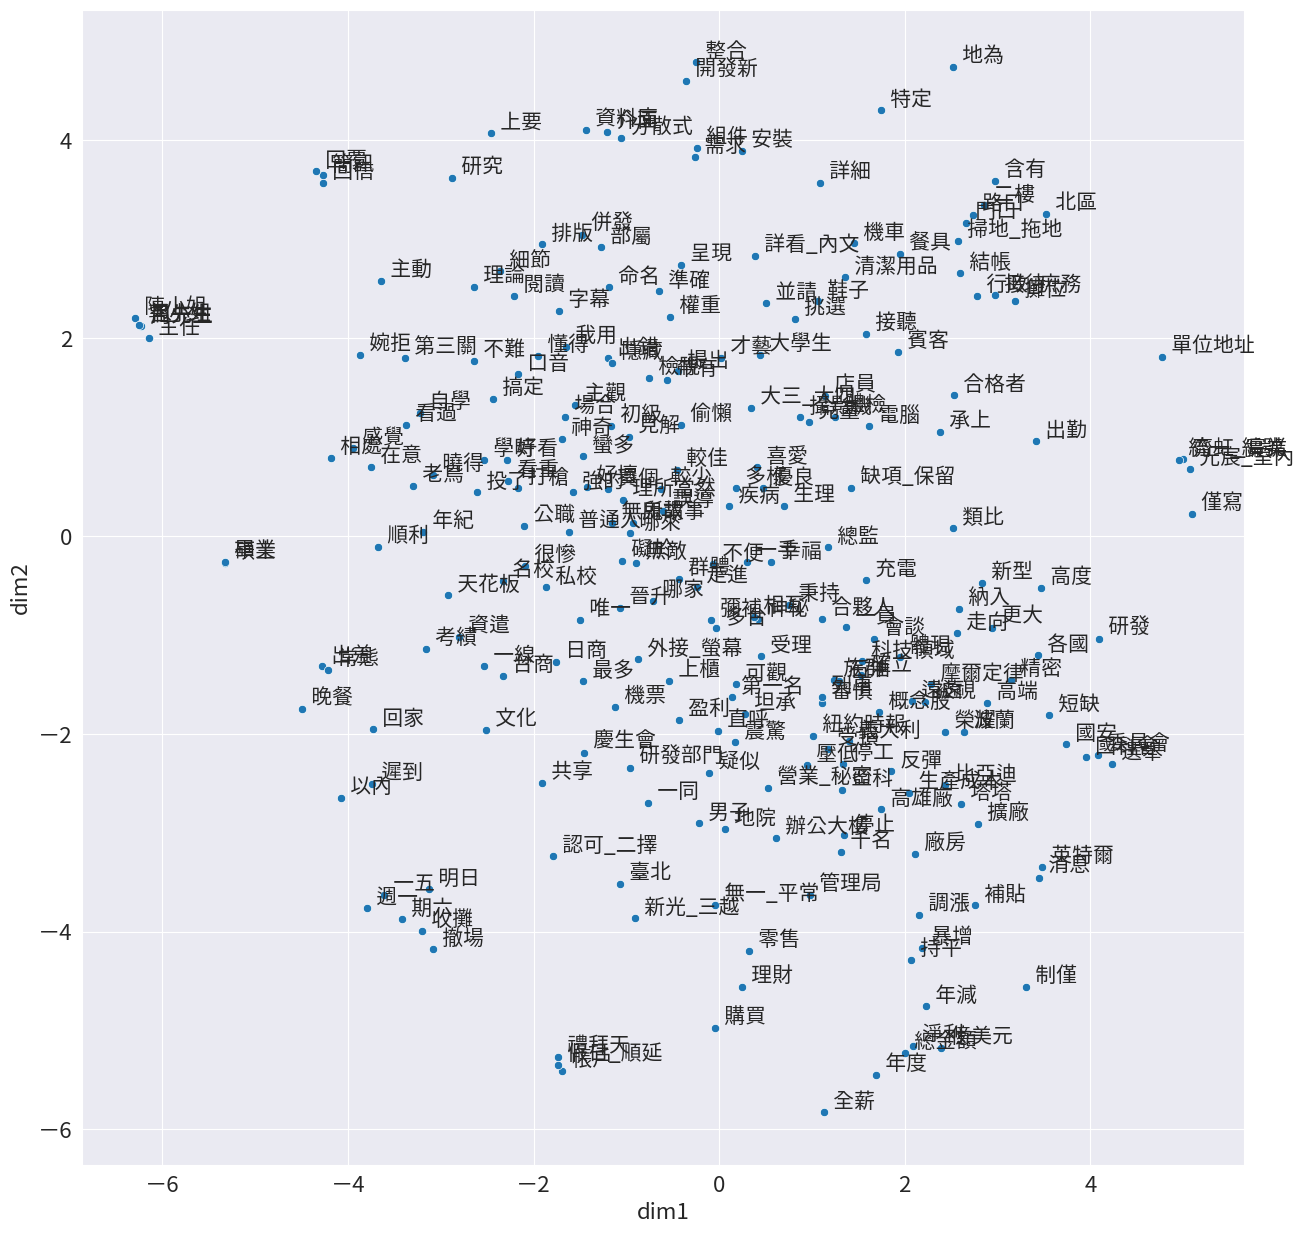

In [34]:
plotScatter(word_df)

3D 散狀圖

In [35]:
new_feat = reduceDim(feat,dim = 3,method = 'TSNE',perplexity=50,learning_rate = 50)
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(250, 3)


將字分群

In [36]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00


In [37]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [39]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

In [41]:
word_df1 = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=6),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df1)

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [42]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [43]:
from sentence_transformers import SentenceTransformer, models, util

#### 小模型，以BERT為範例

註：在挑選語言模型時需確認其訓練資料的來源，因為不一定都具備跨語言的能力。   
接下來將以針對中文以及多語言進行訓練的BERT模型做範例。

因為後續在查看結果時會一直使用到此程式碼，所以包成function以便之後使用。

In [44]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

多語言 bert-base-multilingual-cased

In [ ]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

#### 大模型範例

In [45]:
!pip install tiktoken
!pip install utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=b220c15bada2e19f8ce82bf287acf7d5c93a1da8dcf8f38bf161921bfd569b8f
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


#### Open Source LLM

In [ ]:
from huggingface_hub import notebook_login
#notebook_login() # 輸入Hugging Face 帳號的Token

##### Microsoft - Phi 4

In [ ]:
# model_phi3 = SentenceTransformer('microsoft/Phi-3.5-mini-instruct')
model_phi4 = SentenceTransformer('microsoft/Phi-4-mini-instruct')

model_phi4.tokenizer.pad_token = model_phi4.tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

這裡需注意一下，上述的開源LLM基本上是decoder-only，它們主要的任務目標是要生成下一個字，並不是主要拿來做sentence embedding的。   
有興趣的同學可以參考[embedding相關任務的leaderboard](https://huggingface.co/spaces/mteb/leaderboard)，試試上面的模型。

### 使用embedding做NLP任務

#### 相似文件

In [71]:
df_similar = origin_data.loc[:, ['system_id','artTitle', 'artContent']]
df_similar = df_similar.astype({ "artContent": "str", "artTitle": "str" })
df_similar['artContent'] = df_similar['artContent'].str.replace("[^\u4e00-\u9fa5]", "", regex=True)

df_similar.head(5)

,system_id,artTitle,artContent
0,1,[個人]桃園搬家助手1/1兩位,本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...
1,2,[台北/市調]維他命座談會車馬費1500元,本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...
2,3,[多區/個人]PPT製作,本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...
3,4,[多區/個人]網頁Logo設計,本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...
4,5,[個人]西語電視台徵求攝影師跟拍(學生可),本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...


In [72]:
# 資料前處理

# 移除警告標語
warns = ["本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範",
         "本人願意為本文內容負責，並保証本文內容皆詳盡屬實，若違反相關規範，願受處分",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "提醒：上方二行文字不得刪除或變更",
         "違者文章逕行刪除",
         "本行提醒得Ctrl+Y刪除之",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "為必填項目，缺項應保留空項目名稱，灰色文字得刪除之",
         "各項均不得為「面議」",
         "本文僅授權發表於PTT實業坊",
         "未經同意不得轉載至其它網站",
         "本人保留一切訴訟權",
         "否則得視情況提出告訴",
         "承攬制等不適用排班、休息之工作者僅填第一項「交件期」，其餘項留空白",
         "一次性工作且未滿四小時者，得將全部資訊填於第一項，其餘項留空白",
         "不定期工作，第一項「工作期」應填「長期」及可開始工作日",
         "第二項「排班方式」應填每週或每月何日出勤(休息)，或現場排班等，一次性工作留空",
         "第三、四項「工作時間」「休息時間」得合併至第三項，第四項留空白",
         "第四項「休息時間」、第五項「休息計薪供餐」依實際情形填寫之(第五項擇一)",
         "任一項僅寫「面議」或同義文字者，一律水桶一年並退文"]

for warn in warns:
    warn = warn.replace(r"[^\u4e00-\u9fa5]", "")

    df_similar["artContent"] = df_similar["artContent"].str.replace(warn, "")


使用 bert-base-chinese

In [65]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

取得整個文集的 embeddings

In [73]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=128
)

In [74]:
query_num = 6789 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [心得]科技業10年簡單心得

 資料集中前五相似的文章:
[心得]科技業10年簡單心得 (Score: 1.0000)
[請益]職涯問題請教（代po） (Score: 0.9882)
Re:進了想要的工作又後悔了 (Score: 0.9880)
Re:[請益]快40歲...--年齡對工程師真的是個問題嗎？ (Score: 0.9879)
[心得]日本遊戲業程式轉職心得 (Score: 0.9872)






In [75]:
query_num = 1234

top_k = 5

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [高雄/個人]幫忙老屋清理搬東西等勞動

 資料集中前五相似的文章:
[高雄/個人]幫忙老屋清理搬東西等勞動 (Score: 1.0000)
[台中/派遣]日本展日文工讀生9/16、9/23 (Score: 1.0000)
[台北市/個人]搬運物品 (Score: 1.0000)
[個人]台北市師大附近徵陪玩 (Score: 1.0000)
[高雄/個人]4/8漢神夜間進場小幫手1500/元 (Score: 1.0000)






In [76]:
df_similar.iloc[1234]

,1234
system_id,1235
artTitle,[高雄/個人]幫忙老屋清理搬東西等勞動
artContent,本人同意並願意遵守現行法律本站使用者條款本站各級規定本板所有規範本人願意為本文內容負責並保証...


### 分類任務
使用bert-base-chinese模型對新聞資料集做embeddings，接著訓練分類器。（參考week7程式碼）

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('你的雲端資料夾路徑') #切換該目錄
os.listdir() #確認目錄內容

In [ ]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [ ]:
origin_data_parttime = pd.read_csv('./raw_data/ptt_parttime.csv')
origin_data_techjob = pd.read_csv('./raw_data/ptt_techjob.csv')
origin_data_softjob = pd.read_csv('./raw_data/ptt_softjob.csv')

origin_data = pd.concat([
    origin_data_parttime,
    origin_data_techjob,
    origin_data_softjob
], ignore_index=True)

origin_data.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/part-time/M.1704039923....,[個人]桃園搬家助手1/1兩位,2024-01-01 00:25:21,snk236,part_time,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,[],114.136.39.28,2024-01-01 02:09:00,ptt
1,2,https://www.ptt.cc/bbs/part-time/M.1704068173....,[台北/市調]維他命座談會車馬費1500元,2024-01-01 08:16:11,Portmento,part_time,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""GUANGLEI"", ""...",125.229.192.37,2024-01-02 02:11:21,ptt
2,3,https://www.ptt.cc/bbs/part-time/M.1704077270....,[多區/個人]PPT製作,2024-01-01 10:47:48,bonzi42,part_time,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,[],118.165.136.221,2024-01-02 02:11:21,ptt


In [ ]:
# 資料前處理

metaData = origin_data.copy()

# 移除警告標語
warns = ["本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範",
         "本人願意為本文內容負責，並保証本文內容皆詳盡屬實，若違反相關規範，願受處分",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "提醒：上方二行文字不得刪除或變更",
         "違者文章逕行刪除",
         "本行提醒得Ctrl+Y刪除之",
         "誤刪者應至本板使用規範第37條或z-53-3複製範本",
         "為必填項目，缺項應保留空項目名稱，灰色文字得刪除之",
         "各項均不得為「面議」",
         "本文僅授權發表於PTT實業坊",
         "未經同意不得轉載至其它網站",
         "本人保留一切訴訟權",
         "否則得視情況提出告訴",
         "承攬制等不適用排班、休息之工作者僅填第一項「交件期」，其餘項留空白",
         "一次性工作且未滿四小時者，得將全部資訊填於第一項，其餘項留空白",
         "不定期工作，第一項「工作期」應填「長期」及可開始工作日",
         "第二項「排班方式」應填每週或每月何日出勤(休息)，或現場排班等，一次性工作留空",
         "第三、四項「工作時間」「休息時間」得合併至第三項，第四項留空白",
         "第四項「休息時間」、第五項「休息計薪供餐」依實際情形填寫之(第五項擇一)",
         "任一項僅寫「面議」或同義文字者，一律水桶一年並退文"]

for warn in warns:
    metaData["artContent"] = metaData["artContent"].str.replace(warn, "")

In [ ]:
# 移除空文章
print(f"Art content na number : {metaData['artContent'].isna().sum()}")
metaData.dropna(subset="artContent",inplace=True)
metaData.reset_index(inplace=True,drop=True)

# 移除網址
metaData["artContent"] = metaData["artContent"].str.replace("(http|https)://.*", "", regex=True)
metaData["artTitle"] = metaData["artTitle"].str.replace("(http|https)://.*", "", regex=True)

# 只保留中文字（去除非中文字，包括英數符號）
metaData["artContent"] = metaData["artContent"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)
metaData["artTitle"] = metaData["artTitle"].str.replace("[^\u4e00-\u9fa5]", "", regex=True)

# 日期轉換與欄位整理
metaData['artDate'] = pd.to_datetime(metaData['artDate'])

# 只保留需要的欄位
metaData = metaData.loc[:, ["artContent", "artUrl", "artCatagory", 'artDate']]
metaData = metaData.astype({ "artContent": "str", "artUrl": "str" })

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData = metaData[metaData['sentence'].apply(len) > 0]

metaData.head(10)

Art content na number : 22


,artContent,artUrl,artCatagory,artDate,sentence
0,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,https://www.ptt.cc/bbs/part-time/M.1704039923....,part_time,2024-01-01 00:25:21,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...
1,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,https://www.ptt.cc/bbs/part-time/M.1704068173....,part_time,2024-01-01 08:16:11,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...
2,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,https://www.ptt.cc/bbs/part-time/M.1704077270....,part_time,2024-01-01 10:47:48,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...
3,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...,https://www.ptt.cc/bbs/part-time/M.1704078649....,part_time,2024-01-01 11:10:47,工作或交件期晚上以前預定排班方式自行安排每日工作時間自行安排每日休息時間無休息計薪供餐皆無以...
4,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...,https://www.ptt.cc/bbs/part-time/M.1704084465....,part_time,2024-01-01 12:47:43,工作或交件期台灣大選前後與當日約三日實際時間可議預定排班方式無每日工作時間八小時以內視記者採...
5,工作或交件期預定排班方式無每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐皆無以上時間...,https://www.ptt.cc/bbs/part-time/M.1704085782....,part_time,2024-01-01 13:09:40,工作或交件期預定排班方式無每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐皆無以上時間...
6,工作或交件期撕除壁貼僅一面牆可先給照片本週內預定排班方式無每日工作時間小時時薪每日休息時間可...,https://www.ptt.cc/bbs/part-time/M.1704097191....,part_time,2024-01-01 16:19:49,工作或交件期撕除壁貼僅一面牆可先給照片本週內預定排班方式無每日工作時間小時時薪每日休息時間可...
7,工作或交件期寒假期間預定排班方式輪班制每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐...,https://www.ptt.cc/bbs/part-time/M.1704101881....,part_time,2024-01-01 17:37:59,工作或交件期寒假期間預定排班方式輪班制每日工作時間每日休息時間工作滿小時休息分鐘休息計薪供餐...
8,工作或交件期預定排班方式每日每日工作時間每日每日休息時間中午休息計薪供餐皆有以上時間未註明單...,https://www.ptt.cc/bbs/part-time/M.1704115238....,part_time,2024-01-01 21:20:36,工作或交件期預定排班方式每日每日工作時間每日每日休息時間中午休息計薪供餐皆有以上時間未註明單...
9,工作或交件期長期周一至周六預定排班方式月排班每日工作時間可商議每日休息時間工作滿小時休息分鐘...,https://www.ptt.cc/bbs/part-time/M.1704116155....,part_time,2024-01-01 21:35:53,工作或交件期長期周一至周六預定排班方式月排班每日工作時間可商議每日休息時間工作滿小時休息分鐘...


In [ ]:
metaData["embeddings"] = metaData.artContent.apply(lambda x: bert_ch.encode(x, batch_size=128))
metaData.head(3)

,artContent,artUrl,artCatagory,artDate,sentence,embeddings
0,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,https://www.ptt.cc/bbs/part-time/M.1704039923....,part_time,2024-01-01 00:25:21,工作日期每日工作時間每日休息時間無休息有無計薪供餐無平常日工資一次應為時薪或日薪不得為月薪計...,"[0.3379488, -0.21154355, -0.38119745, -0.03219..."
1,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,https://www.ptt.cc/bbs/part-time/M.1704068173....,part_time,2024-01-01 08:16:11,台北市維他命座談會車馬費元民國年次女性目前主要使用的維他命產品為善存不包含銀寶善存克補專科大...,"[0.41755936, 0.032123484, -0.44641522, 0.19462..."
2,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,https://www.ptt.cc/bbs/part-time/M.1704077270....,part_time,2024-01-01 10:47:48,工作或交件期年早上前將內容檔案傳給你下午前收件預定排班方式每日工作時間每日休息時間工作滿小時...,"[0.5365565, 0.055052776, -0.3852287, -0.173162..."


In [ ]:
import numpy as np
from ast import literal_eval

In [ ]:
data = metaData.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

            0         1         2         3         4         5         6    \
13401  0.560306 -0.321858 -0.330510  0.161176 -0.179881 -0.140227  0.141266   
14108  0.278214 -0.268822 -0.232446  0.188849 -0.121889 -0.303135 -0.099489   
854    0.558776 -0.001759 -0.368538 -0.197690 -0.183597 -0.339740 -0.078512   
16060  0.534518 -0.235673 -0.158103  0.301618 -0.207532 -0.070196  0.113609   
15473  0.671602 -0.231409 -0.014904  0.353978  0.094284 -0.474395  0.071826   

            7         8         9    ...       758       759       760  \
13401  0.178856 -0.079364 -0.279886  ... -0.037840 -0.042293  0.197094   
14108  0.210736 -0.327837 -0.381075  ... -0.131986 -0.073621  0.319670   
854    0.096544 -0.032030 -0.359192  ... -0.154268 -0.554613  0.218479   
16060 -0.058289 -0.068432 -0.308061  ...  0.005796 -0.156044  0.230008   
15473  0.194140  0.152012 -0.088710  ...  0.022566  0.058994  0.219675   

            761       762       763       764       765       766       767  
13

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
print(y_pred[:10])

['part_time' 'Tech_Job' 'part_time' 'Tech_Job' 'Tech_Job' 'Soft_Job'
 'Tech_Job' 'part_time' 'part_time' 'Soft_Job']


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Soft_Job       0.85      0.88      0.87      1612
    Tech_Job       0.88      0.85      0.87      1634
   part_time       1.00      0.99      0.99      1644

    accuracy                           0.91      4890
   macro avg       0.91      0.91      0.91      4890
weighted avg       0.91      0.91      0.91      4890



# 第三次讀書會：BERT (Encoder-only-model)
---

本週課程為「BERT (Encoder-only-model)」，主要會介紹不同 BERT 相關下游任務的程式碼應用，學習目標著重在如何使用 BERT 相關資源（例如網路上別人訓練好的 BERT 模型）來達成 Token classification、Sequence classification 以及 Text Clustering 等等相關文字處理任務。

課程：社群媒體分析

授課教授：黃三益老師

組別：Group_2

組員：M124020028,何允中、M134020016,王予芙、M134020034,黃沛萱、M134020037,陳宥齊、M124111057,張伶宣


---


資料來源：ptt

版別：軟體工作

+ 步驟：
    * 載入套件、資料
    * 資料前處理
    * Token classification
      * NER
    * Sequence classification
      * Sentiment Classification
      * Relation Extraction(RE)
    * Text Clustering
      * BERTopic 的 Embedding model<br>
      * BERTopic 的 Clustering model<br>
      * 套用中文資料<br>
      * 使用Representation方法去微調主題表示


遇到的困難和解決方式

  * 初次使用 BERTopic 建模中文文本時，僅產生少量主題，且大量資料被歸為未分類（Topic -1），無法有效反映語料中的語意多樣性。

可能原因

* HDBSCAN 預設參數過於保守，原本 min_cluster_size=15 導致模型只保留大型主題，忽略小型語意群。

* 語料數量不足
　　初期僅使用約 500 筆資料，語意分布稀疏，不利於穩定聚類。

改進措施
* 調整聚類參數:降低聚類門檻，提升模型對小主題的辨識能力。

* 擴充語料筆數:擴增文本數量，使語意空間更完整，改善分群效果。


### 1. 套件介紹

連接雲端資料夾

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA2025') # 請將這行修改為自己的 google drive 路徑
os.listdir() # 確認目錄內容

Mounted at /content/drive


['TaipeiSansTCBeta-Regular.ttf', 'raw_data', 'dict', 'week12_bert.ipynb']

**前處理常用套件**


In [ ]:
# !pip install jieba

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

**Transformers 和 Sentence-transformers （使用 huggingface 模型）**

In [ ]:
!pip install sentence_transformers
!pip install ckip_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopic套件**

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

中文資料集：ppt softwork版資料集

In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('/content/drive/MyDrive/SMA2025/raw_data/softjob_23_25.csv')
origin_data.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,appleboy46,Soft_Job,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""loadingN"", ""...",123.110.136.13,2023-01-02 02:02:59,ptt
1,2,https://www.ptt.cc/bbs/Soft_Job/M.1672559293.A...,[請益]北漂Offer金融vs假外商,2023-01-01 15:48:11,carsun00,Soft_Job,背景：\n 私立資工學士\n 軟體經驗5Y，後端為主，可以支援前端/CICD\n\n ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""xyzb"", ""cmtC...",111.252.104.32,2023-01-02 02:02:59,ptt
2,3,https://www.ptt.cc/bbs/Soft_Job/M.1672571470.A...,[請益]有人的公司也沒有提供API文件的嗎,2023-01-01 19:11:08,cv123741,Soft_Job,安安\n\n小弟剛轉前端，進到一家接案公司寫網頁，工作大概9成都在接API，\n但公司內部沒...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""newbout"", ""c...",112.78.88.96,2023-01-02 02:03:00,ptt
3,4,https://www.ptt.cc/bbs/Soft_Job/M.1672628999.A...,Re:[請益]有人的公司也沒有提供API文件的嗎,2023-01-02 11:09:57,lovdkkkk,Soft_Job,:\n:\n:\n:\n:\n:\n:\n幾種可能做法\n\n1. 寫在 issue com...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""MoonCode"", ""...",111.241.213.212,2023-01-03 02:03:26,ptt
4,5,https://www.ptt.cc/bbs/Soft_Job/M.1672638492.A...,[請益]學C++能從事那個領域的工作？,2023-01-02 13:48:10,wsad50232,Soft_Job,從網路上的資訊得知\n如果是從事韌體開發 則用的都是C\n如果是從事web開發\n則用的都是...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""plsmaop"", ""c...",36.229.34.53,2023-01-03 02:03:26,ptt


In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 替換掉換行符號，以利後續分句
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

# 依標點符號切句
metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

# 清洗：保留句子中的中文字（不要蓋掉 explode 結果）
import re
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)) if isinstance(x, str) else '')

# 篩除空白句子
metaData = metaData[metaData['sentence'].str.strip().str.len() > 1].reset_index(drop=True)

metaData.head(10)


,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務
1,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,當系統內有需要處理比較久或較多資源的任務
2,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,肯定會將這些任務丟到其他機器再執行
3,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,執行過程如果需要取消
4,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,會經過如上圖幾個步驟
5,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,先假設中間的過程不透過機制
6,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,而是兩個服務進行溝通透過或方式
7,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,使用情境
8,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,可以看到步驟一是會先發請求到後端服務
9,1,https://www.ptt.cc/bbs/Soft_Job/M.1672537150.A...,[分享]系統設計:如何取消正在執行的工作任務,2023-01-01 09:39:03,文字教學:\nhttps://bit.ly/3jFMwvS\n教學影片:\nhttps://...,詢問目前正在執行的任務是否取消


英文資料集：載入傲慢與偏見

In [ ]:
# 讀入英文示範資料集
en_origin_data = pd.read_csv('/content/drive/MyDrive/SMA2025/raw_data/en_sentence_chapter.csv')
en_origin_data.head()

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
1,"It is a truth universally acknowledged, that a...",1
2,However little known the feelings or views of ...,1
3,"""My dear Mr. Bennet,"" said his lady to him one...",1
4,Mr. Bennet replied that he had not.,1


## 3. Token classification

### NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

如果找不到自己適用的模型的話，也可以透過 fine-tune 來建立自己的模型。<br>
本課程因為時間與資源因素，僅針對「如何使用網路上他人 fine-tune 好的模型」進行程式碼示範，不提供 fine-tune 程式碼範例。<br>
如有需要，可參考 Huggingface 相關教學文章：[Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)

#### 3.1 中文 NER：<br>
- 使用套件：transformers<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 載入中文NER模型
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# 建立pipeline方便處理，傳入task type、model、tokenizer
ner_pipe = pipeline('ner', model=model, tokenizer=tokenizer)
example = ["在環遊世界的3年裡，威尼斯我最愛的城市。"]

# 進行NER識別，輸出dict list
ner_results = ner_pipe(example)
ner_results

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

[[{'entity': 'B-DATE',
   'score': np.float32(0.9999993),
   'index': 7,
   'word': '3',
   'start': 6,
   'end': 7},
  {'entity': 'E-DATE',
   'score': np.float32(0.9999994),
   'index': 8,
   'word': '年',
   'start': 7,
   'end': 8},
  {'entity': 'B-GPE',
   'score': np.float32(0.99999833),
   'index': 11,
   'word': '威',
   'start': 10,
   'end': 11},
  {'entity': 'I-GPE',
   'score': np.float32(0.9999988),
   'index': 12,
   'word': '尼',
   'start': 11,
   'end': 12},
  {'entity': 'E-GPE',
   'score': np.float32(0.9999989),
   'index': 13,
   'word': '斯',
   'start': 12,
   'end': 13}]]

也可以使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
- 使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
- 使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 初始化 ckip 工具 device=0 使用GPU ｜ device=-1 使用CPU（速度會很慢）
# Mac使用者可以設定 device=torch.device("mps") 使用GPU
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NER識別

# 想要進行處理的句子
text = [
   "傅達仁今將執行安樂死，卻突然爆出自己20年前遭緯來體育台封殺，他不懂自己哪裡得罪到電視台。",
   "美國參議院針對今天總統布什所提名的勞工部長趙小蘭展開認可聽證會，預料她將會很順利通過參議院支持，成為該國有史以來第一位的華裔女性內閣成員。"
]

# 執行NER
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Tokenization: 100%|██████████| 2/2 [00:00<00:00, 3721.65it/s]

Inference: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

Tokenization: 100%|██████████| 2/2 [00:00<00:00, 3985.09it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]

Tokenization: 100%|██████████| 2/2 [00:00<00:00, 4060.31it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00, 47.65it/s]


In [ ]:
# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

# 顯示處理結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   print(sentence)
   print(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   for entity in sentence_ner:
      print(entity)
   print()

傅達仁今將執行安樂死，卻突然爆出自己20年前遭緯來體育台封殺，他不懂自己哪裡得罪到電視台。
傅達仁(Nb)　今(Nd)　將(D)　執行(VC)　安樂死(Na)　，(COMMACATEGORY)　卻(D)　突然(D)　爆出(VJ)　自己(Nh)　20(Neu)　年(Nf)　前(Ng)　遭(P)　緯來(Nb)　體育台(Na)　封殺(VC)　，(COMMACATEGORY)　他(Nh)　不(D)　懂(VK)　自己(Nh)　哪裡(Ncd)　得罪到(VC)　電視台(Nc)　。(PERIODCATEGORY)
NerToken(word='傅達仁', ner='PERSON', idx=(0, 3))
NerToken(word='20年', ner='DATE', idx=(18, 21))
NerToken(word='緯來體育台', ner='ORG', idx=(23, 28))

美國參議院針對今天總統布什所提名的勞工部長趙小蘭展開認可聽證會，預料她將會很順利通過參議院支持，成為該國有史以來第一位的華裔女性內閣成員。
美國(Nc)　參議院(Nc)　針對(P)　今天(Nd)　總統(Na)　布什(Nb)　所(D)　提名(VC)　的(DE)　勞工部長(Na)　趙小蘭(Nb)　展開(VC)　認可(VC)　聽證會(Na)　，(COMMACATEGORY)　預料(VE)　她(Nh)　將(D)　會(D)　很(Dfa)　順利(VH)　通過(VC)　參議院(Nc)　支持(Nv)　，(COMMACATEGORY)　成為(VG)　該(Nes)　國(Nc)　有史以來(D)　第一(Neu)　位(Nf)　的(DE)　華裔(Na)　女性(Na)　內閣(Na)　成員(Na)　。(PERIODCATEGORY)
NerToken(word='美國參議院', ner='ORG', idx=(0, 5))
NerToken(word='今天', ner='LOC', idx=(7, 9))
NerToken(word='布什', ner='PERSON', idx=(11, 13))
NerToken(word='勞工部長', ner='ORG', idx=(17, 21))
NerToken(word='趙小蘭', ner='PERSON', idx=(21, 24))
NerToken(word='認

**將CKIP套用到我們先前處理好的資料集**

In [ ]:
# 以前50筆資料作為範例
text = metaData['sentence'].tolist()
text = text[:50]

# 執行處理
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)


Inference: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


,sentence,packed_sentence,entities
0,文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務,文字(Na) 教學(VA) 教學(Nv) 影片(Na) 範例(Na) 程式(Na) 系統(N...,[]
1,當系統內有需要處理比較久或較多資源的任務,當(P) 系統(Na) 內(Ncd) 有(V_2) 需要(VK) 處理(VC) 比較(Dfa...,[]
2,肯定會將這些任務丟到其他機器再執行,肯定(VK) 會(D) 將(P) 這些(Neqa) 任務(Na) 丟到(VC) 其他(Neq...,[]
3,執行過程如果需要取消,執行(Nv) 過程(Na) 如果(Cbb) 需要(VK) 取消(VC),[]
4,會經過如上圖幾個步驟,會(D) 經過(VCL) 如(VG) 上(Ncd) 圖(Na) 幾(Neu) 個(Nf) 步...,[]
5,先假設中間的過程不透過機制,先(D) 假設(VE) 中間(Ncd) 的(DE) 過程(Na) 不(D) 透過(P) 機制...,[]
6,而是兩個服務進行溝通透過或方式,而是(Cbb) 兩(Neu) 個(Nf) 服務(VC) 進行(VC) 溝通(VC) 透過(P...,"[NerToken(word='兩', ner='CARDINAL', idx=(2, 3))]"
7,使用情境,使用(Nv) 情境(Na),[]
8,可以看到步驟一是會先發請求到後端服務,可以(D) 看到(VE) 步驟(Na) 一(Neu) 是(SHI) 會(D) 先(VA) 發...,"[NerToken(word='一', ner='ORDINAL', idx=(6, 7))]"
9,詢問目前正在執行的任務是否取消,詢問(VE) 目前(Nd) 正在(D) 執行(VC) 的(DE) 任務(Na) 是否(D) ...,[]


可以依據前幾週的程式碼，對 NER 後的句子進行近一步的探索

**注意：不同的 NER 模型因為 fine-tune 的方法與資料不相同，所以不同的 NER 模型間，Entity Types 不一定相同。<br>**
以使用醫學領域資料 fine-tune 的 NER 模型為例：https://huggingface.co/Clinical-AI-Apollo/Medical-NER
- 根據模型的描述：
```Medical NER Model finetuned on BERT to recognize 41 Medical entities.``` 可以看出這個NER模型和一般的NER模型識別的Entity type不同

#### 3.2 英文 NER：
使用套件：transformers<br>
使用的 NER 模型：https://huggingface.co/dslim/bert-base-NER

In [ ]:
# 載入英文NER模型和其對應的Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# 建立pipeline方便處理
nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]

ner_results = nlp(example)
ner_results

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


[[{'entity': 'B-PER',
   'score': np.float32(0.9990139),
   'index': 4,
   'word': 'Wolfgang',
   'start': 11,
   'end': 19},
  {'entity': 'B-LOC',
   'score': np.float32(0.999645),
   'index': 9,
   'word': 'Berlin',
   'start': 34,
   'end': 40}],
 [{'entity': 'B-PER',
   'score': np.float32(0.9987392),
   'index': 1,
   'word': 'Obama',
   'start': 0,
   'end': 5},
  {'entity': 'B-LOC',
   'score': np.float32(0.99977475),
   'index': 4,
   'word': 'USA',
   'start': 12,
   'end': 15}]]

## 4. Sequence classification

### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒(start 1到star 5)：<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name)

# 使用模型來進行情緒分析
text = ["我喜歡這部電影！", "他的行為讓我很困擾"]
result = model(text)

# 輸出結果(標籤和分數)
result


config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'star 4', 'score': 0.4818800389766693},
 {'label': 'star 1', 'score': 0.2434728592634201}]

In [ ]:
from transformers import pipeline
import pandas as pd
import numpy as np

# 初始化 pipeline，加入 truncation=True 保證不超過 BERT 長度限制
analyze = pipeline("sentiment-analysis", model="bert-base-chinese", tokenizer="bert-base-chinese")

# 建立新 dataframe 儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義分析函數（處理空句子 & 長度裁切）
def analyze_sentiment(sentence):
    if not isinstance(sentence, str) or len(sentence.strip()) == 0:
        return pd.Series(["neutral", 0.0])  # 或其他預設值
    try:
        result = analyze(sentence, truncation=True)
        return pd.Series([result[0]['label'], result[0]['score']])
    except Exception as e:
        print(f"Error on sentence: {sentence[:30]}... -> {e}")
        return pd.Series(["error", 0.0])

# 使用 apply 分析所有句子
results_df[['label', 'score']] = results_df['sentence'].apply(analyze_sentiment)

# 顯示前幾筆結果
results_df.head(10)


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,sentence,label,score
0,文字教學教學影片範例程式系統架構圖本篇來聊聊如何取消正在執行的工作任務,LABEL_0,0.576561
1,當系統內有需要處理比較久或較多資源的任務,LABEL_0,0.563461
2,肯定會將這些任務丟到其他機器再執行,LABEL_0,0.527270
3,執行過程如果需要取消,LABEL_1,0.573647
4,會經過如上圖幾個步驟,LABEL_0,0.596149
5,先假設中間的過程不透過機制,LABEL_0,0.568344
6,而是兩個服務進行溝通透過或方式,LABEL_1,0.540877
7,使用情境,LABEL_0,0.534509
8,可以看到步驟一是會先發請求到後端服務,LABEL_1,0.501461
9,詢問目前正在執行的任務是否取消,LABEL_0,0.520067


### 4.2 Relation Extraction (RE)
使用 Huggingface 上面已經針對 RE 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/teppei727/bert-large-relation14

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("teppei727/bert-large-relation14")
model = AutoModelForSequenceClassification.from_pretrained("teppei727/bert-large-relation14")
re_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 使用模型來進行 RE
text = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]
result = re_model(text)

# 輸出結果
result

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': '[no connective]', 'score': 0.5112523436546326},
 {'label': 'Expansion.Conjunction', 'score': 0.6735802888870239}]

In [ ]:
# 建立一個新的 dataframe 來儲存結果
re_results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
re_results_df['sentence'] = en_origin_data['sentence']

# 定義一個函數來進行 RE 任務
def get_re_result(sentence):
    result = re_model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行 RE 任務
re_results_df[['label', 'score']] = en_origin_data['sentence'].apply(get_re_result)

# 輸出結果
re_results_df.head(10)

,sentence,label,score
0,﻿TPRIDE & PREJUDICE.,[no connective],0.996502
1,"It is a truth universally acknowledged, that a...",Expansion.Conjunction,0.946982
2,However little known the feelings or views of ...,Expansion.Conjunction,0.962074
3,"""My dear Mr. Bennet,"" said his lady to him one...",Expansion.Conjunction,0.658448
4,Mr. Bennet replied that he had not.,Expansion.Conjunction,0.772690
5,"""But it is,"" returned she; ""for Mrs. Long has ...",Expansion.Conjunction,0.955999
6,Mr. Bennet made no answer.,Expansion.Conjunction,0.623749
7,"""Do not you want to know who has taken it?""",Expansion.Conjunction,0.362443
8,cried his wife impatiently.,Expansion.Conjunction,0.872732
9,"""_You_ want to tell me, and I have no objectio...",Expansion.Conjunction,0.379491


注意：RE 跟 NER 一樣，不同的模型會有不同的關係型態，尤其是使用特定領域資料 fine-tune 的模型，通常會有該特定領域專有的關係型態

## 5. Text Clustering

以下使用 BERTopic 來實作 BERT-based 的 Text Clustering，並介紹 clustering-based 的主題模型<br>
BERTopic: https://maartengr.github.io/BERTopic/index.html<br><br>

簡單介紹BERTopic套件的模組架構，每一列的組件代表不同的處理步驟，主要可以分為兩個階段，其中相同顏色的組件代表可替換的選項：<br>
- **Topic Creation 主題分群**
    - **Embeddings**: 使用語言模型將文本句子轉換成向量，用於進行分群
    - **Dimension Reduction**: 把高維度的語意向量降維方便後續處理
    - **Clustering**: 把降維後的語意向量進行分群（主題）
---
- **Topic Representation 主題表示**
    - **Tokenizer**: 將文本句子的詞進行轉換成可計算的表示
    - **Topic Representation**: 從每個主題中抽取出主題的關鍵代表詞
---
除此之外，新版本的BERTopic也提供了方法去進一步微調每個主題表示，可以使用GPT、KEYBERT、Spacy等模型或方法去調整並找出更好的主題模型的代表詞或標籤。

#### 5.1 基本用法介紹

In [ ]:
docs = en_origin_data['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2" # Embeddings layer
hdbscan_model = HDBSCAN() # Clustering layer
vectorizer_model = CountVectorizer()

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs[:500])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,143,-1_of_the_and_in,"[of, the, and, in, to, you, be, he, not, she]",[Bingley had never met with pleasanter people ...
1,0,47,0_you_it_not_do,"[you, it, not, do, that, but, yes, is, did, no]","[""It will be no use to us, if twenty such shou..."
2,1,41,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, the, of, ...","[Mr. Bennet replied that he had not., ""How goo..."
3,2,33,2_darcy_mr_to_his,"[darcy, mr, to, his, of, the, and, at, was, with]",[Between him and Darcy there was a very steady...
4,3,26,3_bingley_mr_miss_her,"[bingley, mr, miss, her, you, his, may, and, t...",[I dare say Mr. Bingley will be very glad to s...
5,4,26,4_jane_was_her_she,"[jane, was, her, she, elizabeth, the, and, to,...","[Elizabeth, easy and unaffected, had been list..."
6,5,19,5_is_enough_love_it,"[is, enough, love, it, woman, of, but, she, mu...","[When she is secure of him, there will be leis..."
7,6,18,6_you_agreeable_flatter_agree,"[you, agreeable, flatter, agree, nerves, yet, ...","[Well, he certainly is very agreeable, and I g..."
8,7,17,7_eliza_dance_danced_he,"[eliza, dance, danced, he, with, you, the, mis...",[He paused in hopes of an answer; but his comp...
9,8,17,8_lucas_miss_to_the,"[lucas, miss, to, the, william, his, lady, and...",[Sir William Lucas had been formerly in trade ...


In [ ]:
# 列出Topic 6的關鍵字和其對應的c TF-IDF分數
topic_model.get_topic(6)

[('you', np.float64(0.06404198632957502)),
 ('agreeable', np.float64(0.06095631898384444)),
 ('flatter', np.float64(0.054504017120069706)),
 ('agree', np.float64(0.050431288822319086)),
 ('nerves', np.float64(0.050431288822319086)),
 ('yet', np.float64(0.04754823645379035)),
 ('give', np.float64(0.04531703686866793)),
 ('good', np.float64(0.04484353369300437)),
 ('to', np.float64(0.044269350172206394)),
 ('your', np.float64(0.041657657375517035))]

In [ ]:
# 列出前10筆文章的BERTopic資訊
doc_topic_info = topic_model.get_document_info(docs[:500])
doc_topic_info.head(10)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,﻿TPRIDE & PREJUDICE.,-1,-1_of_the_and_in,"[of, the, and, in, to, you, be, he, not, she]",[Bingley had never met with pleasanter people ...,of - the - and - in - to - you - be - he - not...,0.000000,False
1,"It is a truth universally acknowledged, that a...",13,13_single_fortune_one_man,"[single, fortune, one, man, or, of, is, husban...",[A single man of large fortune; four or five t...,single - fortune - one - man - or - of - is - ...,1.000000,True
2,However little known the feelings or views of ...,-1,-1_of_the_and_in,"[of, the, and, in, to, you, be, he, not, she]",[Bingley had never met with pleasanter people ...,of - the - and - in - to - you - be - he - not...,0.000000,False
3,"""My dear Mr. Bennet,"" said his lady to him one...",1,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, the, of, ...","[Mr. Bennet replied that he had not., ""How goo...",bennet - mrs - mr - netherfield - that - the -...,0.521473,False
4,Mr. Bennet replied that he had not.,1,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, the, of, ...","[Mr. Bennet replied that he had not., ""How goo...",bennet - mrs - mr - netherfield - that - the -...,1.000000,True
5,"""But it is,"" returned she; ""for Mrs. Long has ...",16,16_long_mrs_will_it,"[long, mrs, will, it, told, introduce, him, th...",[But I can guess how it was; every body says t...,long - mrs - will - it - told - introduce - hi...,0.729211,False
6,Mr. Bennet made no answer.,1,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, the, of, ...","[Mr. Bennet replied that he had not., ""How goo...",bennet - mrs - mr - netherfield - that - the -...,1.000000,False
7,"""Do not you want to know who has taken it?""",0,0_you_it_not_do,"[you, it, not, do, that, but, yes, is, did, no]","[""It will be no use to us, if twenty such shou...",you - it - not - do - that - but - yes - is - ...,0.898734,False
8,cried his wife impatiently.,-1,-1_of_the_and_in,"[of, the, and, in, to, you, be, he, not, she]",[Bingley had never met with pleasanter people ...,of - the - and - in - to - you - be - he - not...,0.000000,False
9,"""_You_ want to tell me, and I have no objectio...",0,0_you_it_not_do,"[you, it, not, do, that, but, yes, is, did, no]","[""It will be no use to us, if twenty such shou...",you - it - not - do - that - but - yes - is - ...,0.877081,False


In [ ]:
# 視覺化主題分布：圓圈大小是主題的大小，圓圈的距離是主題之間的相似度
topic_model.visualize_topics()

#### 5.2 Embedding model<br>
BERTopic 支援多種 embedding 模型與方法，包含基本的 Huggingface 模型，也提供了 LLM-based 的 embedding 可做選擇。<br>
更多請參考文件：https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#scikit-learn-embeddings

In [ ]:
# 使用 sentence_transformers 相關語言模型作為 embedding_model
sentence_model = SentenceTransformer("google-bert/bert-base-uncased")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（sentence_model）
embed_topic_model = BERTopic(embedding_model=sentence_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = embed_topic_model.fit_transform(docs[:500])

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#### 5.3 Clustering model<br>
參考文件：https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html

調整 topic modeling 流程中的 clustering 算法

In [ ]:
# 使用 KMeans 作為分群算法，需要指定分群個數
cluster_model = KMeans(n_clusters=10)

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 hdbscan_model 替換為其他模型（cluster_model）
kmeans_topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, vectorizer_model=vectorizer_model)
topics, probs = kmeans_topic_model.fit_transform(docs[:500])

kmeans_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,67,0_you_it_not_but,"[you, it, not, but, do, that, is, in, to, them]","[""It will be no use to us, if twenty such shou..."
1,1,63,1_of_is_to_it,"[of, is, to, it, are, in, but, be, the, you]",[We can all _begin_ freely--a slight preferenc...
2,2,62,2_bingley_the_and_mr,"[bingley, the, and, mr, of, to, was, in, her, ...",[His sisters were very anxious for his having ...
3,3,54,3_he_and_the_to,"[he, and, the, to, in, her, had, his, was, of]",[But no sooner had he made it clear to himself...
4,4,52,4_you_will_not_it,"[you, will, not, it, my, have, to, and, long, ...","[But if _we_ do not venture, somebody else wil..."
5,5,50,5_her_was_she_jane,"[her, was, she, jane, the, and, of, to, elizab...","[She was shewn into the breakfast-parlour, whe..."
6,6,49,6_darcy_to_lucas_mr,"[darcy, to, lucas, mr, the, his, and, of, with...","[And taking her hand, he would have given it t..."
7,7,49,7_bennet_mrs_of_the,"[bennet, mrs, of, the, mr, that, to, said, and...","[Mr. Bennet replied that he had not., ""How goo..."
8,8,30,8_dance_lizzy_he_not,"[dance, lizzy, he, not, eliza, with, the, you,...",[He paused in hopes of an answer; but his comp...
9,9,24,9_oh_officers_you_did,"[oh, officers, you, did, the, to, pieces, leng...","[""Oh!, ""Oh!, ""Oh!""]"


查看 text clustering 結果

In [ ]:
topics[:10]

[6, 1, 7, 7, 7, 4, 7, 0, 2, 0]

#### 5.4 套用於中文<br>
為了套用到中文文章，各元件必須修改為支援中文的方法，主要針對 embedding model 以及 tokenizer

In [ ]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:1200]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
#hdbscan_model = HDBSCAN()

# 預設 min_cluster_size=15，建議調小，如 5~10
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=1)

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

2025-05-10 16:00:03,748 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 16:00:06,915 - BERTopic - Dimensionality - Completed ✓
2025-05-10 16:00:06,916 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 16:00:06,957 - BERTopic - Cluster - Completed ✓
2025-05-10 16:00:06,961 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from /content/drive/MyDrive/SMA2025/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/SMA2025/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u1da137ab21bce317209202f0e92c1948.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u1da137ab21bce317209202f0e92c1948.cache
Loading model cost 1.573 seconds.
DEBUG:jieba:Loading model cost 1.573 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2025-05-10 16:00:08,699 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,257,-1_ _寫_規格_公司,"[ , 寫, 規格, 公司, 快, 大部分, 開發, 時間, 做, 找, 獎金, 真的, 台...","[產品目前的行為就是規格, 此時規格的目的不再是為了完成產品, 最近接到一個專案要爬購物網站..."
1,0,271,0_ _薪資_台灣_軟體,"[ , 薪資, 台灣, 軟體, 工程師, 公司, 產業, 工作, 工時, 資訊, 員工, 加...","[攻城精英就業保證班提供各行各業潛在菁英成為軟體開發資訊人才的機會, 是軟體工程師的一種, ..."
2,1,245,1_ _公司_做_想,"[ , 公司, 做, 想, 面試, 寫, 發現, 工作, 說, 上班, 有人, 時間, 真的...",[加上太太薪資比我高很多除了孝親跟一個小朋友以外就沒什麼壓力但太太一直說怎麼有人換工作越換錢...
3,2,177,2_ _問卷_執行_瀏覽器,"[ , 問卷, 執行, 瀏覽器, 端, 請求, 數據分析, 覆核, 頁面, 取消, 步驟, ...","[還要考慮它是否為一份需要覆核但沒被覆核完成但已經審核完成的問卷, 而需要覆核的問卷要先審核..."
4,3,88,3_ _規格_舊有_不好,"[ , 規格, 舊有, 不好, 放手, 犯錯, 做法, 選擇, 觀念, 寫, 簡單, 解決,...","[選擇放手時間, 但又不想寫規格, 規格不好寫]"
5,4,73,4_ _謝謝_億_大勝,"[ , 謝謝, 億, 大勝, 否, 統編, 萬, 職缺, 一年, 端, 前端, 三面, 轉,...","[謝謝, 謝謝, 謝謝]"
6,5,28,5_前輩_推薦_請_參考,"[前輩, 推薦, 請, 參考, 希望, 分享, 書籍, 整理, , 建議, 請問, 有沒有...","[請各位資深前輩不吝指教, 請各位前輩指點迷津謝謝, 再請大大推薦書籍了]"
7,6,24,6_老師_課程_曾瑞君_吳,"[老師, 課程, 曾瑞君, 吳, 永志, 推吳, 刪掉, 收費, 版上, 課, 找到, ,...","[吳老師的課程, 吳永志老師的課程, 都是曾瑞君老師的課程較好]"
8,7,14,7_連結_影片_媒體_內容摘要,"[連結, 影片, 媒體, 內容摘要, 完整, 轉載, 新聞, 責任編輯, 中央社, 授權, ...","[影片連結內容摘要, 影片連結內容摘要, 影片連結內容摘要]"
9,8,12,8_框架_內容_工作_扁平,"[框架, 內容, 工作, 扁平, 缺少, 組織, 性質, 發案, 還學過, 快速, 接軌, ...","[工作內容使用框架為, 工作內容使用框架為, 工作內容使用框架為]"


In [ ]:
zh_topic_model.visualize_topics()

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 2/2 [00:00<00:00,  7.24it/s]


In [ ]:
# 以第50個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[50])

In [ ]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(7)

[('連結', np.float64(0.42284979217422786)),
 ('影片', np.float64(0.31650564251039626)),
 ('媒體', np.float64(0.2520719106213591)),
 ('內容摘要', np.float64(0.2520719106213591)),
 ('完整', np.float64(0.23823986695677224)),
 ('轉載', np.float64(0.18106864859316354)),
 ('新聞', np.float64(0.18106864859316354)),
 ('責任編輯', np.float64(0.10168465810358034)),
 ('中央社', np.float64(0.10168465810358034)),
 ('授權', np.float64(0.10168465810358034)),
 ('截自', np.float64(0.10168465810358034)),
 ('新聞標題', np.float64(0.10168465810358034)),
 ('眼淚', np.float64(0.10168465810358034)),
 ('本文', np.float64(0.10168465810358034)),
 ('更新', np.float64(0.10168465810358034)),
 ('內文', np.float64(0.10168465810358034)),
 ('以下內容', np.float64(0.10168465810358034)),
 ('編輯', np.float64(0.10168465810358034)),
 ('署名', np.float64(0.10168465810358034)),
 ('核稿', np.float64(0.10168465810358034)),
 ('滴', np.float64(0.10168465810358034)),
 ('附上', np.float64(0.09053432429658177)),
 ('網址', np.float64(0.09053432429658177)),
 ('時代', np.float64(0.0905343

查看特定文章的主題分佈

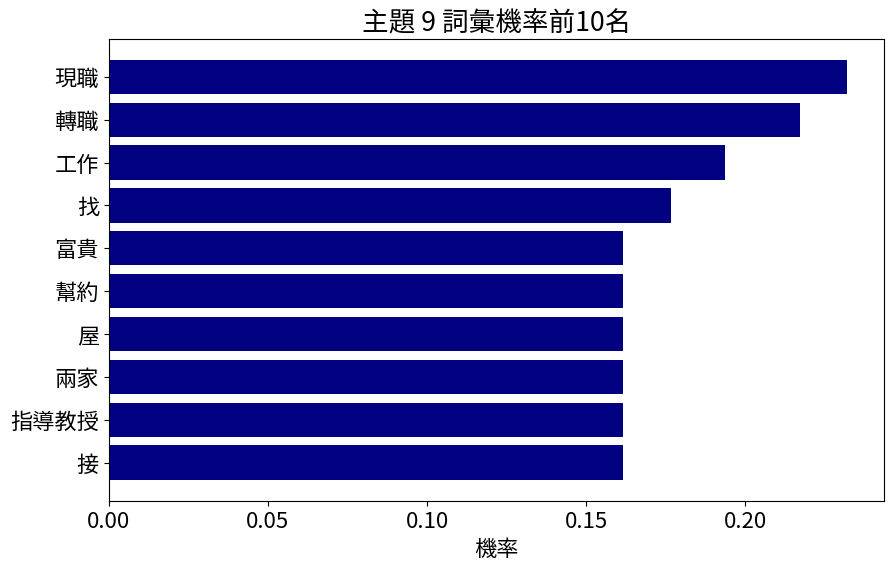

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 9
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

#### 5.5 用模型進行主題標籤的調整
新版本的BERTopic提供許多方法供我們調整以c TF-IDF的主題表示，讓我們能得到更能準確描述各個文件集合的字詞去描述每個主題。

目前的Representation方法大致分成兩種：
- 非生成模型：專注於調整或改善每個主題表示的關鍵字
- 生成模型：會根據每個主題的詞語和代表文件，去標記或總結主題

在這邊我們先以KeyBERT非生成模型方法做示範如何去調整BERTopic的主題表示詞語

##### KeyBERT方法說明
---
KeyBERT是一種文本關鍵字提取模型，其方法是透過計算文本中每個N-gram或者token字詞和文件本身之間得BERT embedding的餘弦相似度，去找到文件的關鍵字。
BERTopic根據KeyBERT的方法去建立了一個應用於每個Topic的關鍵字提取流程，架構如下圖所示。

1. 首先針對Topic n，會先依據這個主題的c TF-IDF去找出最能代表主題的幾篇文件，和最能代表主題的幾個候選關鍵代表字。
    - 候選關鍵代表字是根據c TF-IDF的大小去排序，找出前Ｎ個代表字
    - 主題的代表文件挑選方法是比較主題的c TF-IDF和每篇文件的c TF-IDF
2. 接著會利用BERT去產生這些文件和候選代表字的Embedding向量
    - 其中所有代表文件的Embedding向量會取平均作為這個Topic n的向量表示
3. 接著去計算Topic n的向量表示和每個候選代表字的Embedding向量的相似度去找出這個Topic n的最終代表字

根據這個調整後KeyBERT的方法，就能快速的去調整並找出每個主題的代表關鍵字。

In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model（同學如果想比較其他模型可以在這邊加入其他模型方法）
representation_model = {
    "KeyBERT": keybert,
}

In [ ]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-10 16:31:08,202 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 16:31:11,840 - BERTopic - Dimensionality - Completed ✓
2025-05-10 16:31:11,842 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 16:31:11,909 - BERTopic - Cluster - Completed ✓
2025-05-10 16:31:11,916 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 16:31:12,263 - BERTopic - Representation - Completed ✓


In [ ]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,8,-1_遭霸凌_台_安穩_何要,"[遭霸凌, 台, 安穩, 何要, 上雲學, 標題新聞, 看板, 新聞標題, 殘憶, , 作...","[新聞標題, 標題新聞, 謝謝, 遭霸凌, 影片, 作者, 完整, 安穩, 殘憶, 何要]","[影片標題為何要上雲學, 完整新聞標題表示在台遭霸凌, 作者安穩殘憶看板標題新聞表示在台遭霸凌]"
1,0,1179,0_ _公司_工作_薪資,"[ , 公司, 工作, 薪資, 台灣, 寫, 做, 開發, 軟體, 工程師, 想, 資訊, ...","[數據分析, 工程師, 有沒有, 程式, 瀏覽器, 規格, 使用者, 公司, 單位, 老師]","[但應不應該寫規格就看公司文化, 這主要是對許多美國大公司的軟體工程師職位薪資以及職等的資料..."
2,1,13,1_連結_影片_媒體_內容摘要,"[連結, 影片, 媒體, 內容摘要, 新聞, 轉載, 完整, , 截自, 以下內容, 更新...","[內容摘要, 以下內容, 影片, 責任編輯, 附上, 連結, 網頁, 截自, 內文, 媒體]","[影片連結內容摘要, 影片連結內容摘要, 影片連結內容摘要]"


主題表示的微調方法除了KeyBERT以外還有MMR、Spacy等多種方法，除此之外也能進一步透過生成模型的方法進行主題的標籤生成，例如：GPT、Llama等，由於教材篇幅以及方法的複雜性原因，這邊另外提供同學們BERTopic的官方網站說明以及Llama示範的colab程式碼。

有興趣的同學可以參考並嘗試替換不同方法去調整主題的代表詞，或者進一步用生成模型對每個生成主題進行標記或者總結，去更好的解釋每個主題的內容。

- BERTopic官網說明：https://maartengr.github.io/BERTopic/getting_started/representation/representation.html
- 使用地端Llama模型進行BERTopic總結：https://colab.research.google.com/drive/1QCERSMUjqGetGGujdrvv_6_EeoIcd_9M?usp=sharing
